# Case study: Shear Wave Elastography (SWE)

## A (very) brief introduction to SWE

Most of the information below is taken from the article of Cacko and Lewandowski [Cacko2022].  

Ultrasound shear wave elastography (SWE) has emerged as a promising technique that enables the quantitative estimation of soft tissue stiffness.
The SWE technique relies on remotely inducing tissue displacement using the acoustic radiation force (ARF), as first proposed by Sarvazyan et al. [Sarvazyan1998].
The ARF is generated by an ultrasound beam (also called a push beam or push pulse) and is defined in following equation:

$$
\vec{F} = \frac{2\alpha{}\vec{I}}{c}
$$

where
* $\vec{F}$ - acoustic radiation force,
* $\alpha$ - absorption coefficient, 
* $\vec{I}$ - acoustic intensity, 
* $c$ - speed of sound in the medium. It is usually assumed that in soft tissue $c = 1540 [m/s]$.


As a result of the tissue displacements from applying the ARF, transient shear waves that propagate in the perpendicular direction to the ARF are induced in the elastic medium.
Assuming that soft tissues are incompressible, isotropic, linear and elastic, a local shear modulus $\mu$ can be obtained by finding the local shear wave propagation speed $c_s$,
namely $\mu = \rho{}\cdot{}c_s^2$ , where $\rho$ is the density ( $\approx 1000$ kgm$^{-3}$ for soft tissue).
As for soft tissue, the bulk modulus $B$ is much higher than the shear modulus ( $B \gg \mu$ ) and the Young’s modulus $E$ of the medium can be estimated using:  

$$
E = 3\mu = 3\rho \cdot c_s^2
$$

A general SWE measurement procedure is shown in Figure 1. 
Just as in the vast majority of ultrasonic techniques, the process consists of two stages: 
data acquisition, followed by data processing with image reconstruction. 
First, the ARF is generated in the medium using a push pulse. 
The shear wave motions that result from the impulsive excitation of the ARF can be tracked ultrasonically by detecting small axial displacements
along the shear wave propagation path using pulse–echo ultrasound. 
The shear wave speed (SWS) depends on the characteristics of the elastic medium. 
Typically, high-frame rate plane wave imaging (PWI) must be used for effective shear wave tracking. 
Immediately after the end of the push pulse generation, the scanner switches into a high-frame rate
imaging mode and captures the RF data. 
Then, the RF data are used in the beamforming process to reconstruct a series of images. 
Successive beamformed images are the inputs for the correlation-based algorithm that performs shear wave detection by obtaining the
particle axial displacement of each pixel. 
The known approaches are described in detail in [Pinton2006]. 
Finally, shear wave motion data are used to obtain a tissue stiffness map. 
Several algorithms have been proposed for this, most of which are based on time-of-flight (ToF)
methods.




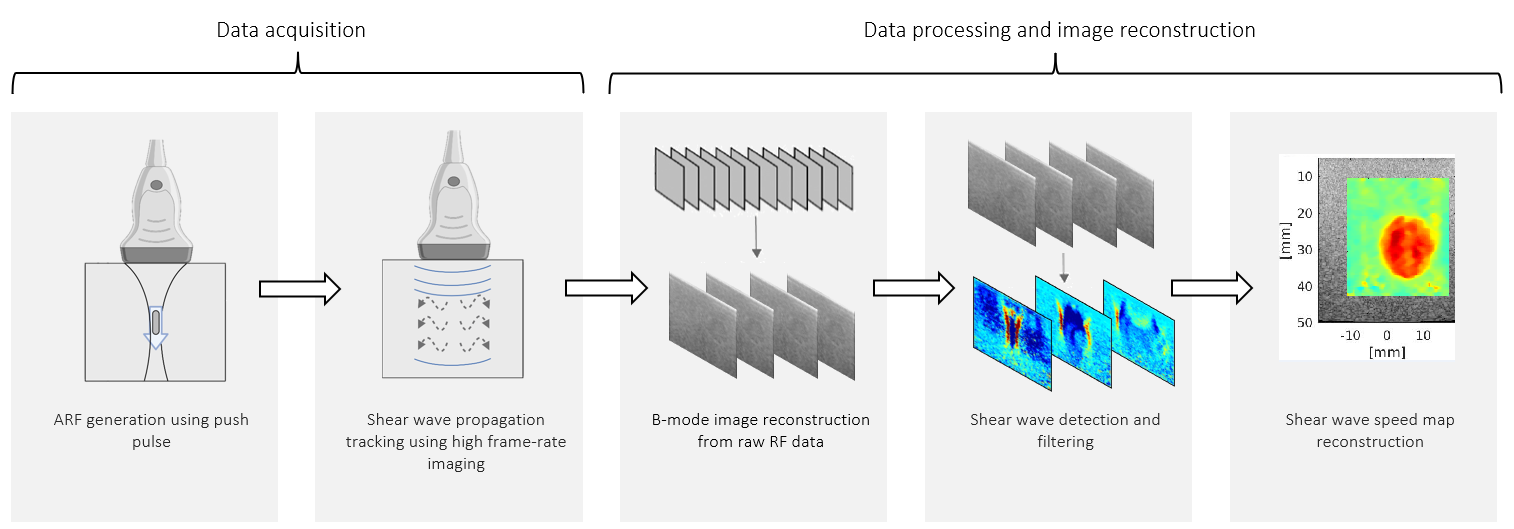


Fig. 1 A general measurement procedure of SWE technique [Cacko2022].

### Outline of data processing used in this notebook

* Compounding (optional)
* Instantaneous signal frequency estimation
* Spatial filtration (separation of two wave fronts)
* Interpolation
* Shear wave speed estimation
* Final filtration (median filter)

We will start from the IQ data array of Low Resolution Images (LRI) acquired after the push pulse. Then, the High Resolution Images (HRI) will be produced using compounding.
These images correspond to successive time intervals, which is refered some times as a 'slow time', in oposition to the 'fast time', which is related to sampling.   
Next, instantaneous frequency of slow-time signal will be estimated for each pixel. We will use IQ algorithm (aka Kasaj [SPRAWDZIC]) for this [REFERENCJA!]
The resulting frequency data will be addidionally processed for SNR increase, and for separation of shear wave-fronts running in opposite direction.
Then the shear wave speed will be estimated using time-of-flight (Tof) method.
Finally, the shear wave speed map undergoes the median filtration, for SNR increase. 


--------------------------------------------------------------------------------

## Let's implement above estimators in GPU kernel, use it, and show some SWE images.   

### 'import' section

In [2]:
import cupy as cp
import cupyx.scipy.ndimage
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from IPython.display import HTML
import gpu_short_course.ultrasound_imaging as usi
# from gpu_short_course.ultrasound_imaging import (
#     ToEnvelope
# )
# # # from gpu_short_course.flow_imaging import (
#     dB,
#     filter_wall_clutter_gpu,
#     iq2bmode_gpu,
#     show_flow,    
#     show_flow_cineloop,
# )




GPU:0: UNAVAILABLE


In [10]:
# Cfg
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["image.aspect"] = "auto"

plt.ioff()

### get some data

In [14]:
def import_data_from_matfile(file):
    from scipy.io import loadmat
    matdata = loadmat(file)
    output = {
        "data":            matdata["data"][0][0][0],
        "type":            matdata["data"][0][0][3][0],
        "fs":              matdata["data"][0][0][4][0][0],
        "pitch":           matdata["data"][0][0][6][0][0],
        "c":               matdata["data"][0][0][7][0][0],
        "pb_Type":         matdata["data"][0][0][8][0],
        "pb_TxFreq":       matdata["data"][0][0][9][0], 
        "pb_TxLength":     matdata["data"][0][0][10][0], 
        "pb_Focus":        matdata["data"][0][0][11][0],
        "pb_CuseBeamsN":   matdata["data"][0][0][12][0][0],
        "pb_CuseBeamsSep": matdata["data"][0][0][13][0][0],
        "pb_TxAperture":   matdata["data"][0][0][14][0],
        "pwi_TxFreq":      matdata["data"][0][0][15][0][0],
        "pwi_TxCycles":    matdata["data"][0][0][16][0][0],
        "pwi_TxAngles":    matdata["data"][0][0][17][0],
        "pwi_TxAperture":  matdata["data"][0][0][18][0][0],
        "pwi_FPS":         matdata["data"][0][0][19][0][0],
    }
    return output


path = "/home/linuser/repos/gpu-short-course/data/SWE/ZK_SWE/"
# path = "/home/ubiq/repos/gpu-short-course/data/"
file = "sweDataset_ZK.mat"
imported = import_data_from_matfile(path+file)

# unpacking some variables
data = imported['data']
fs = imported['fs']
c = imported['c']
pitch = imported['pitch']


(150, 4224, 128)


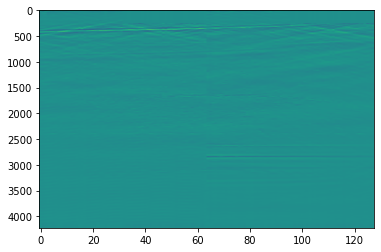

In [42]:
print(data.shape)
plt.imshow(data[0,:,:])
plt.show()

### Kernel definition
KERNEL DESCRIPTION HERE  

The kernel has the following parameters:


In [3]:
compounding_cuda_source = open("compounding.cc").read()
doppler = cp.RawKernel(code=compounding_cuda_source, name='compounding')

### Data loading

First, download example data.

! wget -nc -nv LINK_TO_FILE_HERE -P ./data  

-----------------

DATA DESCRIPTION HERE 

### ELASTICITY estimation using the kernel

In [ ]:
CALCULATIONS HERE

### Presentation of results 

In [ ]:
RESULTS HERE

-----------------------------------------

## References

[Cacko2022] Cacko D.; Marcin Lewandowski, M. Shear Wave Elastography Implementation on a Portable Research Ultrasound System: Initial Results.  Applied Sciences 2022, 12(12), 6210; 
https://doi.org/10.3390/app12126210

[Sarvazyan1998] Sarvazyan, A.P.; Rudenko, O.V.; Swanson, S.D.; Fowlkes, J.B.; Emalianov, S.Y. Shear Wave Elasticity Imaging: A New Ultrasonic Technology of Medical Diagnostics. Ultrasound Med. Biol. 1998, 24, 1419–1435.

[Pinton2006] Pinton, G.F.; Dahl, J.J; Trahey, G.E. Rapid Tracking of Small Displacements with Ultrasound. IEEE Trans. Ultrason. Ferroelectr. Freq.Control 2006, 53, 1103–1117.